# **BEERS ANALYSIS**

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import math
from scipy import stats
import seaborn as sns
from src.data.utils import *
from src.data.utils import dataset_information
import plotly.express as px
import geopandas as gpd

# Files loading

In [6]:
beers_rate = pd.read_csv("data/Processed/RateBeer/beers_processed.csv", sep=",")
beers_adv = pd.read_csv("data/Processed/BeerAdvocate/beers_processed.csv", sep=",")
beers = pd.read_csv("data/Processed/Matched/beers_processed_matched.csv", sep=",")

C:\Users\jon\AppData\Local\Temp\ipykernel_7608\1950828441.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_rate = pd.read_csv("data/Processed/RateBeer/beers_processed.csv", sep=",")


# Initial analysis

Initial inspection of data in the merged dataset:

In [7]:
dataset_information(beers, "Global beers matched dataset")



########################################################
We are starting analysing dataset Global beers matched dataset
- Dimension of starting dataset: (28841, 14)
- Columns of dataset:  Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg', 'abv', 'zscore', 'location', 'location_region',
       'US', 'UK', 'Canada'],
      dtype='object')
- Are all the id unique? Answer: False
- Are there some values that are NaN inside the dataset? Answer: False
Head: 
    beer_id                      beer_name  brewery_id  \
0   170855         3 Sheeps Cirque Du Wit       14215   
1   222750            3 Sheeps First Kiss       14215   
2   494431           3 Sheeps Fresh Coast       14215   
3   348887          3 Sheeps Happy Summer       14215   
4   182392  3 Sheeps Hello My Name is Joe       14215   

               brewery_name                 style  nbr_ratings       avg  abv  \
0  3 Sheeps Brewing Company               Witbier           34  6.553

## Numerical variables

In [18]:
print("avg\n##########################")
print(beers['avg'].describe())
print("##########################\nnbr_ratings\n##########################")
print(beers['nbr_ratings'].describe())

avg
##########################
count    28841.000000
mean         7.169942
std          0.604204
min          0.000000
25%          6.802721
50%          7.097506
75%          7.505669
max         10.000000
Name: avg, dtype: float64
##########################
nbr_ratings
##########################
count    28841.000000
mean        18.715093
std         97.844607
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       6844.000000
Name: nbr_ratings, dtype: float64


In [32]:
beers_not_usa = beers[beers['US'] == False]

beers_not_usa.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg,abv,zscore,location,location_region,US,UK,Canada


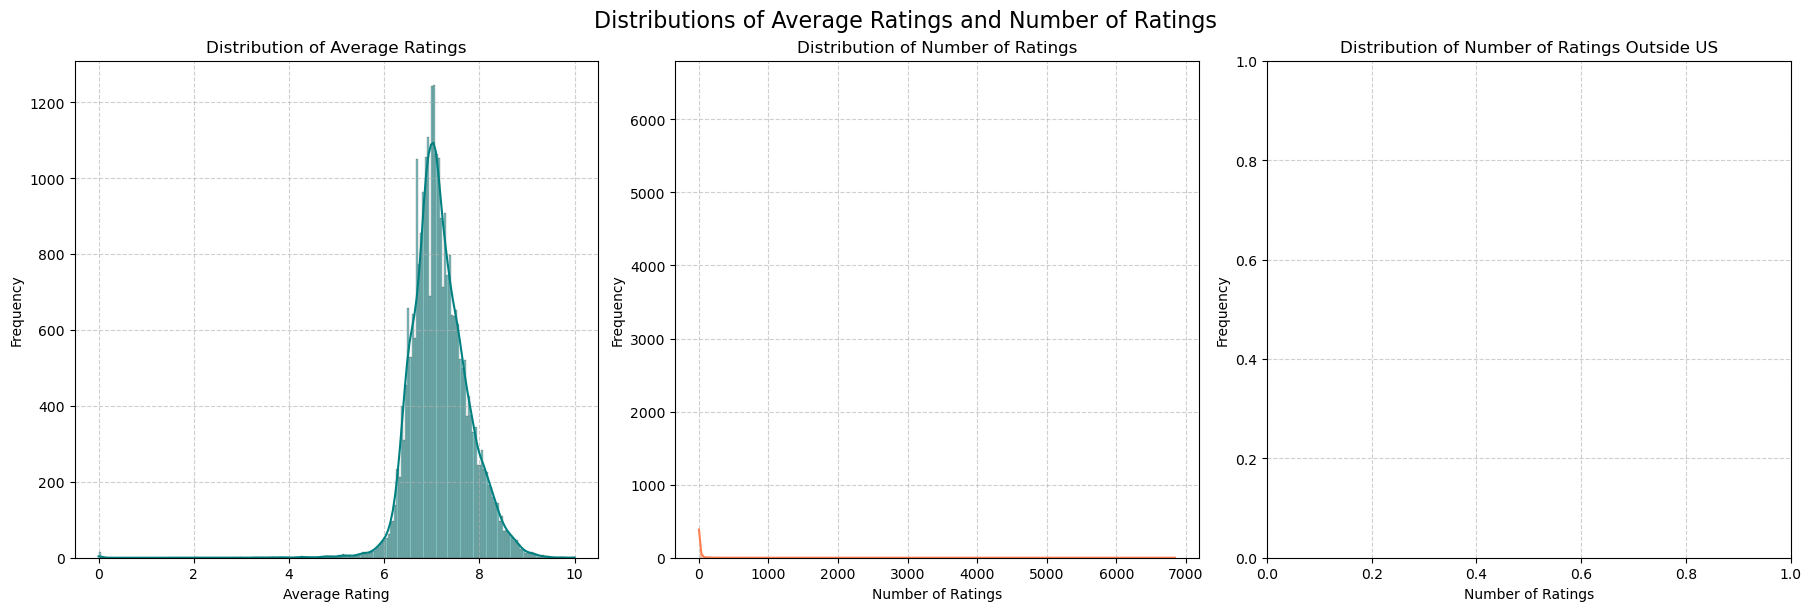

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)


sns.histplot(beers['avg'], kde=True, color='teal', ax=ax1)
ax1.set_title('Distribution of Average Ratings')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Frequency')
ax1.grid(True, linestyle='--', alpha=0.6)

sns.histplot(beers['nbr_ratings'], kde=True, color='coral', ax=ax2)
ax2.set_title('Distribution of Number of Ratings')
ax2.set_xlabel('Number of Ratings')
ax2.set_ylabel('Frequency')
ax2.grid(True, linestyle='--', alpha=0.6)

sns.histplot(beers[beers['US'] == False]['nbr_ratings'], kde=True, color='green', ax=ax3)
ax3.set_title('Distribution of Number of Ratings Outside US')
ax3.set_xlabel('Number of Ratings')
ax3.set_ylabel('Frequency')
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Distributions of Average Ratings and Number of Ratings', fontsize=16)
plt.show()

In [30]:
beers.sort_values(by='nbr_ratings', ascending=False).head(100)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg,abv,zscore,location,location_region,US,UK,Canada
27824,14232,AleSmith Speedway Stout,396,AleSmith Brewing Company,American Double / Imperial Stout,6844,9.085239,12.0,0.878459,United States,California,True,False,False
27972,531,Brooklyn Black Chocolate Stout,45,Brooklyn Brewery,Russian Imperial Stout,6676,8.627859,10.0,0.495761,United States,New York,True,False,False
27986,528,Brooklyn Lager,45,Brooklyn Brewery,American Amber / Red Lager,3643,7.900208,5.2,-0.261546,United States,New York,True,False,False
7444,531,Brooklyn Black Chocolate Stout,90,Brooklyn Brewery,Imperial Stout,3402,9.024943,10.0,1.045310,United States,New York,True,False,False
1194,14232,AleSmith Speedway Stout,432,AleSmith Brewing Company,Imperial Stout,2962,9.750567,12.0,1.568054,United States,California,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28407,154627,Alaskan Freeride APA,429,Alaskan Brewing Co.,American Pale Ale (APA),613,7.858628,5.3,-0.380415,United States,Alaska,True,False,False
28350,169849,West Sixth IPA,28764,West Sixth Brewing Company,American IPA,607,8.170478,7.0,-0.001636,United States,Kentucky,True,False,False
27461,139669,Westbrook India Pale Ale,12402,Westbrook Brewing,India Pale Ale (IPA),604,8.390023,6.8,0.525743,United States,South Carolina,True,False,False
20865,145241,Maine Beer Lunch,10659,Maine Beer Company,India Pale Ale (IPA),599,9.092971,7.0,1.111925,United States,Maine,True,False,False


There are only US beers.

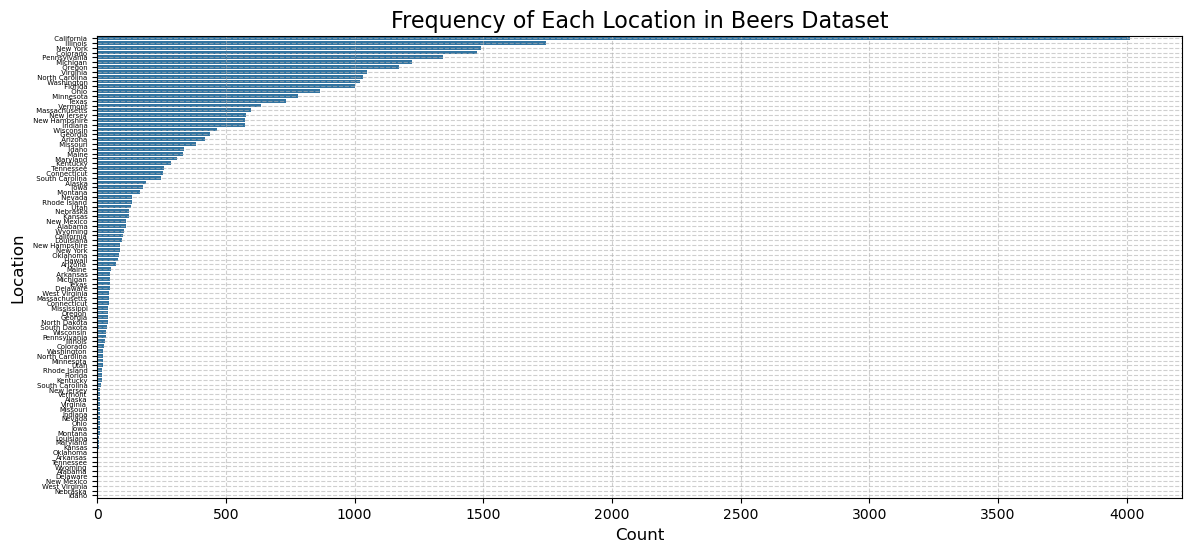

In [41]:
plt.figure(figsize=(14, 6))
sns.barplot(y=beers['location_region'].value_counts().index, 
            x=beers['location_region'].value_counts().values 
            )
plt.title('Frequency of Each Location in Beers Dataset', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [50]:
state_counts = beers['location_region'].value_counts().reset_index()
state_counts.columns = ['state', 'beer_count']

# Map full state names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Convert state names to abbreviations
state_counts['state'] = state_counts['state'].map(us_state_abbrev)

# Calculate log scale for better color differentiation
state_counts['log_beer_count'] = np.log1p(state_counts['beer_count'])

# Create an interactive map with Plotly for US states
fig = px.choropleth(
    state_counts,
    locations="state",
    locationmode="USA-states",  # Use 'USA-states' mode to restrict to US states
    color="log_beer_count",     # Log scale column for coloring
    hover_name="state",
    hover_data={
        "beer_count": True  # Display the original number of beers for clarity
    },
    title="Number of Beers per State in the US (Log Scale)"
)

# Update layout for better appearance and focus on the US
fig.update_geos(
    scope="usa",  # Restrict to USA
    showcoastlines=True,
    coastlinecolor="Gray"
)
fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    coloraxis_colorbar={
        'title': "Number of Beers (Log Scale)",
        'tickvals': [np.log1p(val) for val in [1, 10, 100, 1000, 10000, 100000]],  # Log scale ticks
        'ticktext': ['1', '10', '100', '1k', '10k', '100k']
    }
)

# Display the figure
fig.show()
fig.write_html("us_beer_map.html")
